# TUGAS 12
Cetta Maulana A<br>
1103213119<br>
CNN Modern<br>
DenseNet<br>
CIFAR10<br>
[ChatGPT](https://chatgpt.com/share/f398d823-086f-4a13-9008-017cc739172c)

In [1]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dense, Input, AveragePooling2D, GlobalAveragePooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2024-06-19 15:49:13.308684: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
for i in range(1,6):
    path = 'data_batch_' + str(i)
    with open(path, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
    if i == 1:  
        x_train = (batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)).astype('float32')
        y_train = batch['labels']
    else:
        x_train_temp = (batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)).astype('float32')
        y_train_temp = batch['labels']
        x_train = np.concatenate((x_train,x_train_temp),axis = 0)
        y_train = np.concatenate((y_train,y_train_temp),axis=0)

path = 'test_batch'
with open(path,'rb') as file:
    # note the encoding type is 'latin1'
    batch = pickle.load(file, encoding='latin1')
    x_test = (batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)).astype('float32')
    y_test = batch['labels']

x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0
y_train, y_test = tf.keras.utils.to_categorical(y_train, 10), tf.keras.utils.to_categorical(y_test, 10)


In [3]:
# Define a Dense Block
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        cb = bottleneck_layer(x, growth_rate)
        x = concatenate([x, cb], axis=-1)
    return x

# Define a Bottleneck Layer
def bottleneck_layer(x, growth_rate):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(4 * growth_rate, (1, 1), padding='same', kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(growth_rate, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    
    return x

# Define a Transition Layer
def transition_layer(x, compression):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(x.shape[-1] * compression), (1, 1), padding='same', kernel_initializer='he_normal')(x)
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    return x

# Define the DenseNet model
def build_densenet(input_shape, num_classes, depth, growth_rate, compression):
    num_layers_per_block = (depth - 4) // 6

    inputs = Input(shape=input_shape)
    x = Conv2D(2 * growth_rate, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)

    for _ in range(3):
        x = dense_block(x, num_layers_per_block, growth_rate)
        x = transition_layer(x, compression)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x)

    model = Model(inputs, outputs)
    return model

# Build and compile the DenseNet model
model = build_densenet(input_shape=(32, 32, 3), num_classes=10, depth=40, growth_rate=12, compression=0.5)

2024-06-19 15:49:19.870299: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-19 15:49:19.950009: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-19 15:49:19.950105: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-19 15:49:19.952312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-19 15:49:19.952386: I external/local_xla/xla/stream_executor

In [4]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        672 │ input_layer[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      1,200 │ activation[0][0]  │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        192 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      5,196 │ activation_1[0][… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 36)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        144 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      1,776 │ activation_2[0][… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        192 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      5,196 │ activation_3[0][… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ concatenate[0][0… │
│ (Concatenate)       │ 48)               │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        192 │ concatenate_1[0]

 Total params: 190,540 (744.30 KB)

 Trainable params: 185,452 (724.42 KB)

 Non-trainable params: 5,088 (19.88 KB)

In [5]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test,y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

2024-06-19 15:49:23.391451: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.
2024-06-19 15:49:25.009750: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/100


I0000 00:00:1718812184.135708    7695 service.cc:145] XLA service 0x7ff368001ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718812184.135821    7695 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-19 15:49:44.875007: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-19 15:49:47.416059: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1718812207.070372    7695 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4389 - loss: 1.5375

2024-06-19 15:50:49.684148: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.
2024-06-19 15:50:49.908240: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


782/782 ━━━━━━━━━━━━━━━━━━━━ 88s 61ms/step - accuracy: 0.4390 - loss: 1.5372 - val_accuracy: 0.5615 - val_loss: 1.2399
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.6651 - loss: 0.9375 - val_accuracy: 0.5182 - val_loss: 1.5340
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7273 - loss: 0.7611 - val_accuracy: 0.5793 - val_loss: 1.3890
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7769 - loss: 0.6366 - val_accuracy: 0.7258 - val_loss: 0.7840
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.8061 - loss: 0.5540 - val_accuracy: 0.7736 - val_loss: 0.6503
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.8294 - loss: 0.4865 - val_accuracy: 0.7265 - val_loss: 0.7802
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.8462 - loss: 0.4377 - val_accuracy: 0.6885 - val_loss: 1.0346
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.8632 - loss: 0.3957 - val_

2024-06-19 16:01:00.907766: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8064 - loss: 0.6226
Test accuracy: 0.8083999752998352


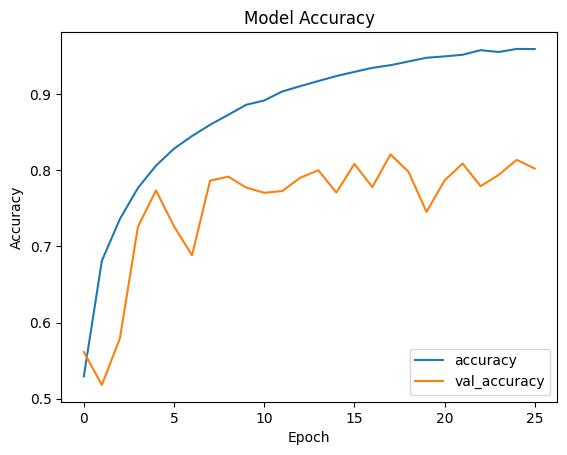

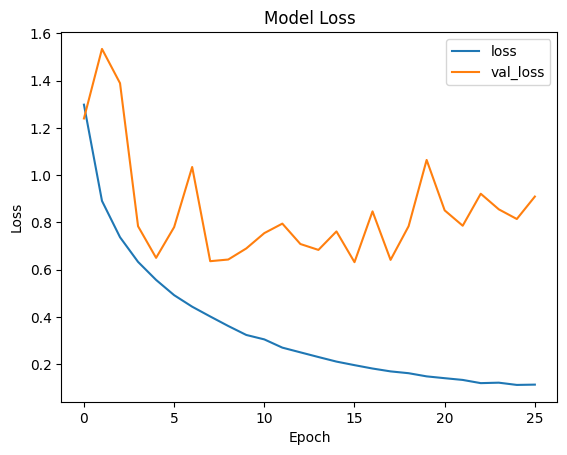

In [6]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()